In [48]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from typing import List


In [77]:
import pandas as pd
import torch

df_train = pd.read_csv('./sign_mnist_train.csv')
df_test = pd.read_csv("./sign_mnist_test.csv")

X_train, y_train = df_train.iloc[:,1:].values/255.0, df_train.iloc[:,0].values #normalizing takes place here
X_test, y_test = df_test.iloc[:,1:].values/255.0, df_test.iloc[:,0].values

value_counts = {value: np.count_nonzero(y_train == value) for value in range(-1, 31)}

print(value_counts)

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer() #One hot encoding of the labels
# y_train = lb.fit_transform(y_train)
# y_test = lb.fit_transform(y_test)

print("X_train numpy shape: "+ str(X_train.shape))
print("X_test numpy shape: " +str(X_test.shape))
print("y_train numpy shape: " +str(y_train.shape))
print("y_test numpy shape: " + str(y_test.shape))


X_train_tensor, y_train_tensor = torch.tensor(X_train).reshape(-1, 28, 28, 1), torch.tensor(y_train) #Reshaped to 2D images for the CNN
X_test_tensor, y_test_tensor = torch.tensor(X_test).reshape(-1,28,28,1), torch.tensor(y_test)

print("X_train tensor shape: "+ str(X_train_tensor.shape))
print("X_test tensor shape: " +str(X_test_tensor.shape))
print("y_train tensor shape: " +str(y_train_tensor.shape))
print("y_test tensor shape: " + str(y_test_tensor.shape))


{-1: 0, 0: 1126, 1: 1010, 2: 1144, 3: 1196, 4: 957, 5: 1204, 6: 1090, 7: 1013, 8: 1162, 9: 0, 10: 1114, 11: 1241, 12: 1055, 13: 1151, 14: 1196, 15: 1088, 16: 1279, 17: 1294, 18: 1199, 19: 1186, 20: 1161, 21: 1082, 22: 1225, 23: 1164, 24: 1118, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0}
X_train numpy shape: (27455, 784)
X_test numpy shape: (7172, 784)
y_train numpy shape: (27455,)
y_test numpy shape: (7172,)
X_train tensor shape: torch.Size([27455, 28, 28, 1])
X_test tensor shape: torch.Size([7172, 28, 28, 1])
y_train tensor shape: torch.Size([27455])
y_test tensor shape: torch.Size([7172])


In [82]:
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None
        
    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError
    

class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.w = np.random.randn(output_size, input_size)
        self.b = np.random.randn(output_size)
        self.cur_input = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cur_input = x
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        #dw = gradient.dot(self.cur_input)
        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        db = gradient
        self.gradient = [dw, db]
        return gradient.dot(self.w)
    

class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient
    

# class SoftmaxOutputLayer(NeuralNetLayer):
#     def __init__(self):
#         super().__init__()
#         self.cur_probs = None

#     def forward(self, x):
#         exps = np.exp(x)
#         probs = exps / np.sum(exps, axis=-1)[:, None]
#         self.cur_probs = probs
#         return probs

#     def backward(self, target):
#         assert self.cur_probs is not None, "Must call forward before backward"
#         return self.cur_probs - target
    
class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        # Shift x by subtracting its max value from each vector in the batch
        shift_x = x - np.max(x, axis=-1, keepdims=True)
        exps = np.exp(shift_x)
        probs = exps / np.sum(exps, axis=-1, keepdims=True)
        self.cur_probs = probs
        return probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target

In [83]:
class MLP:
    def __init__(self, *args: List[NeuralNetLayer]):
        self.layers = args

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)

In [84]:
class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError

class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            g_avg = g.mean(axis=0)
            p -= self.lr * g_avg

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [04:16<00:00, 39.04it/s]


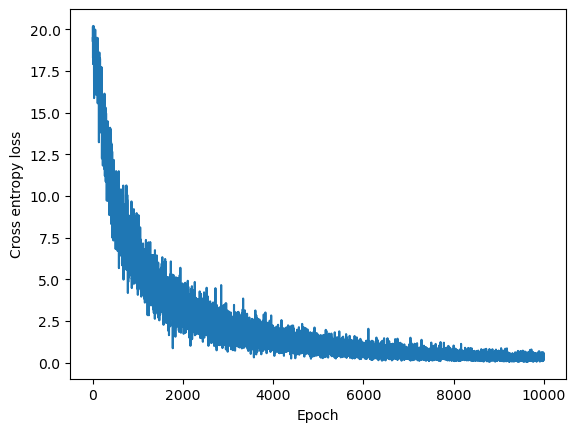

In [93]:
def train(mlp: MLP, optimizer: Optimizer, data_x, data_y, steps, batch_size=64):
    losses = []
    accuracies = []
    n_samples = data_x.shape[0]
    labels_full = np.eye(25)[np.array(data_y)]  # One-hot encode labels
    for _ in tqdm(range(steps)):
        # Randomly select batch indices for each step
        batch_indices = np.random.choice(n_samples, batch_size, replace=False)
        batch_x = data_x[batch_indices]
        batch_y = data_y[batch_indices]
        labels = labels_full[batch_indices]

        predictions = mlp.forward(batch_x)
        predicted_classes = np.argmax(predictions, axis=1)
        correct_predictions = predicted_classes == batch_y
        accuracy = np.mean(correct_predictions)
        accuracies.append(accuracy)
        
        loss = -(labels * np.log(predictions+1e-9)).sum(axis=-1).mean()
        losses.append(loss)
        
        mlp.backward(labels)
        optimizer.step()

    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Cross entropy loss")
    plt.show()

HIDDEN_SIZE = 150
GRADIENT_STEPS = 10000

mlp1 = MLP(
    LinearLayer(784, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 25),
    SoftmaxOutputLayer()
)
opt1 = GradientDescentOptimizer(mlp1, 1e-2)

train(mlp1, opt1, X_train, y_train, GRADIENT_STEPS)

In [95]:
predictions = mlp1.forward(X_train)
predicted_classes = np.argmax(predictions, axis=1)
correct_predictions = predicted_classes == y_train
accuracy = np.mean(correct_predictions)
print(f"Training accuracy: {accuracy*100}%")

predictions_test = mlp1.forward(X_test)
predicted_classes_test = np.argmax(predictions_test, axis=1)
correct_predictions_test = predicted_classes_test == y_test
accuracy_test = np.mean(correct_predictions_test)
print(f"Testing accuracy: {accuracy_test*100}%")

Training accuracy: 92.9484611181934%
Testing accuracy: 56.10708310094813%
